In [1]:
import mysql.connector as mysql
import pyodbc as pdbo
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
# Load libraries
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from sklearn_extra.cluster import KMedoids
server = 'x.database.windows.net'
database = 'x'
username = 'x'
password = '{x}'   
driver= '{ODBC Driver 17 for SQL Server}'

In [2]:
cnxn = pdbo.connect('DRIVER='+driver+';SERVER=tcp:'+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = ("with a as (SELECT  S.Client_ID, I.Groups, SUM(SPD.NetSoldPrice_$) AS SalesMade FROM Sales S, SalesPerDay SPD, Items I WHERE S.SalesNo = SPD.SalesNo AND Client_ID IS NOT NULL AND I.ItemCode = SPD.ItemCode GROUP BY Client_ID, I.Groups),b as (SELECT SUM(a.SalesMade)/COUNT(a.Client_ID) as spending, a.Client_ID, a.Groups FROM a GROUP BY a.Client_ID,a.Groups),d AS (SELECT datediff(YY,Member.DOB,getdate()) as Age, b.*, Member.Client_Name, Member.Gender FROM Member, b WHERE b.Client_ID = Member.Client_ID)select * from d" )
spd = pd.read_sql(query, cnxn)


In [3]:
spd2 = spd
spd2

,Age,spending,Client_ID,Groups,Client_Name,Gender
0,2021.0,3.90,10975,BEVERAGE,LYNETTE,female
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,female
2,2021.0,25.00,101112,FRESH PRODUCE,AGNES KOH,female
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,female
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,female
...,...,...,...,...,...,...
24923,34.0,128.00,301376,SNACK,SUSAN,female
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,female
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,male
24926,43.0,6.50,905,COOKING ESSENTIAL,Monica Lim Ai Chen,female


In [4]:
# Replace the missing value with NaN by using numpy
spd2[['Age','spending','Client_ID','Groups','Client_Name','Gender']] = spd[['Age','spending','Client_ID','Groups','Client_Name','Gender']].replace(' ', np.nan)
# Display the total missing value in the dataset
print(spd2.isnull().sum())

Age            213
spending         0
Client_ID        0
Groups         555
Client_Name    184
Gender         213
dtype: int64


In [5]:
spd2

,Age,spending,Client_ID,Groups,Client_Name,Gender
0,2021.0,3.90,10975,BEVERAGE,LYNETTE,female
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,female
2,2021.0,25.00,101112,FRESH PRODUCE,AGNES KOH,female
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,female
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,female
...,...,...,...,...,...,...
24923,34.0,128.00,301376,SNACK,SUSAN,female
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,female
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,male
24926,43.0,6.50,905,COOKING ESSENTIAL,Monica Lim Ai Chen,female


In [6]:
spd2 = spd2.loc[~(spd2['Age'].isnull()) & ~(spd2['Groups'].isnull())]
spd2

,Age,spending,Client_ID,Groups,Client_Name,Gender
0,2021.0,3.90,10975,BEVERAGE,LYNETTE,female
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,female
2,2021.0,25.00,101112,FRESH PRODUCE,AGNES KOH,female
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,female
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,female
...,...,...,...,...,...,...
24923,34.0,128.00,301376,SNACK,SUSAN,female
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,female
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,male
24926,43.0,6.50,905,COOKING ESSENTIAL,Monica Lim Ai Chen,female


Text(0.5, 1.0, 'SpendingScore')

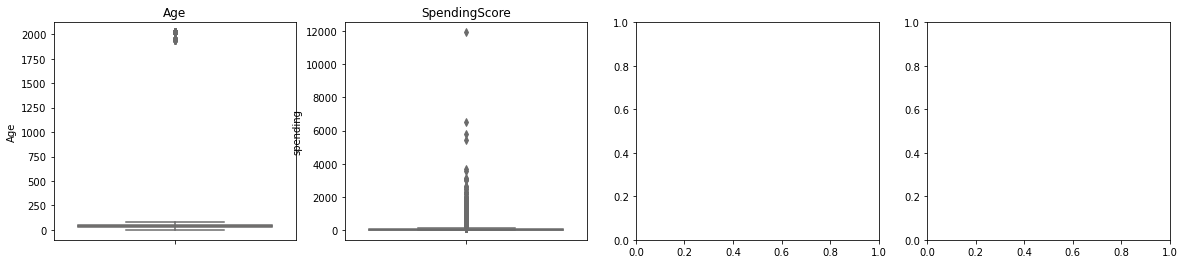

In [7]:
fig, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(y='Age',data=spd2, palette='pink', ax=axes[0])
axes[0].set_title('Age')

sns.boxplot(y='spending',data=spd2, palette='pink', ax=axes[1])
axes[1].set_title('SpendingScore')


In [8]:
Q1 = spd2.quantile(0.25)
Q3 = spd2.quantile(0.75)
IQR = Q3- Q1
print(IQR)

Age         26.0
spending    31.7
dtype: float64


In [9]:
# Remove the outlier data in the dataset by using the method of IQR
spd3 = spd2[~((spd2 < (Q1 - 1.5 * IQR)) | (spd2 > (Q3 + 1.5 * IQR))).any(axis=1)]
# Get the demension in the dataframe after reduce the outlier data by using the method of IQR
print(spd3.shape)

(16992, 6)


C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/632960483.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  spd3 = spd2[~((spd2 < (Q1 - 1.5 * IQR)) | (spd2 > (Q3 + 1.5 * IQR))).any(axis=1)]


In [10]:
spd3

,Age,spending,Client_ID,Groups,Client_Name,Gender
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,female
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,female
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,female
5,35.0,34.50,290174,HEALTH CARE,JEREMY TAN,male
6,27.0,9.00,101370,COOKING ESSENTIAL,TAN MIN EN,female
...,...,...,...,...,...,...
24919,28.0,18.00,10987,CANNING,Lin wai kong,male
24921,30.0,42.70,10970,COOKING ESSENTIAL,Bo Chang Soon,male
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,female
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,male


Text(0.5, 1.0, 'SpendingScore')

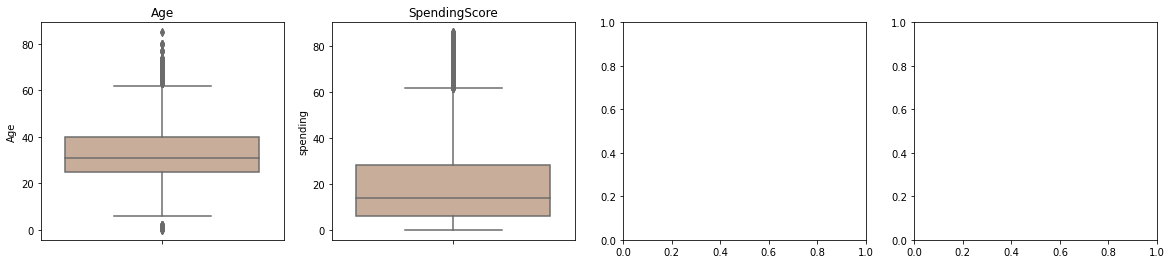

In [11]:
fig, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(y='Age',data=spd3, palette='pink', ax=axes[0])
axes[0].set_title('Age')

sns.boxplot(y='spending',data=spd3, palette='pink', ax=axes[1])
axes[1].set_title('SpendingScore')


In [12]:
Q1 = spd3.quantile(0.25)
Q3 = spd3.quantile(0.75)
IQR = Q3- Q1
print(IQR)

Age         15.0
spending    22.4
dtype: float64


In [13]:
# Remove the outlier data in the dataset by using the method of IQR
spd4 = spd3[~((spd3 < (Q1 - 1.5 * IQR)) | (spd3 > (Q3 + 1.5 * IQR))).any(axis=1)]
# Get the demension in the dataframe after reduce the outlier data by using the method of IQR
print(spd4.shape)

(15713, 6)


C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/2358363056.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  spd4 = spd3[~((spd3 < (Q1 - 1.5 * IQR)) | (spd3 > (Q3 + 1.5 * IQR))).any(axis=1)]


Text(0.5, 1.0, 'SpendingScore')

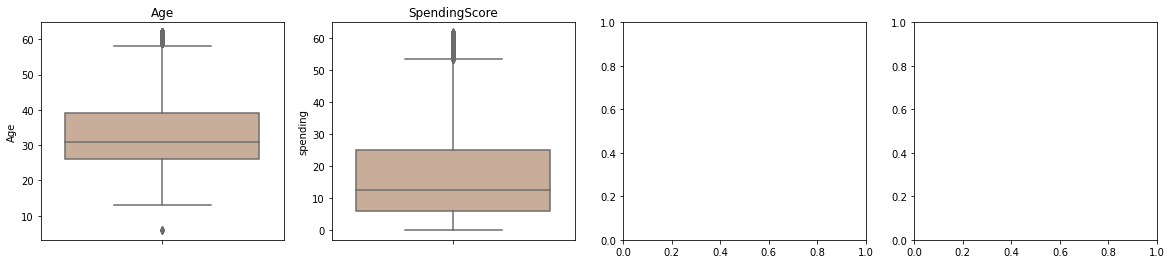

In [14]:
fig, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(y='Age',data=spd4, palette='pink', ax=axes[0])
axes[0].set_title('Age')

sns.boxplot(y='spending',data=spd4, palette='pink', ax=axes[1])
axes[1].set_title('SpendingScore')


In [15]:
spd4.describe()

,Age,spending
count,15713.000000,15713.000000
mean,32.965443,17.107689
std,9.748708,14.746596
min,6.000000,-0.020000
25%,26.000000,5.820000
50%,31.000000,12.500000
75%,39.000000,24.900000
max,62.000000,61.900000


In [16]:
spd5 = spd4[(spd4['spending']>0) & (spd4['Age']>0)]
spd5

,Age,spending,Client_ID,Groups,Client_Name,Gender
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,female
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,female
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,female
5,35.0,34.50,290174,HEALTH CARE,JEREMY TAN,male
6,27.0,9.00,101370,COOKING ESSENTIAL,TAN MIN EN,female
...,...,...,...,...,...,...
24919,28.0,18.00,10987,CANNING,Lin wai kong,male
24921,30.0,42.70,10970,COOKING ESSENTIAL,Bo Chang Soon,male
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,female
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,male


In [17]:
spd5['Gender'] = spd5['Gender'].replace(['female','male'],['0','1'])
spd5

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/3254548044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spd5['Gender'] = spd5['Gender'].replace(['female','male'],['0','1'])


,Age,spending,Client_ID,Groups,Client_Name,Gender
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,0
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,0
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,0
5,35.0,34.50,290174,HEALTH CARE,JEREMY TAN,1
6,27.0,9.00,101370,COOKING ESSENTIAL,TAN MIN EN,0
...,...,...,...,...,...,...
24919,28.0,18.00,10987,CANNING,Lin wai kong,1
24921,30.0,42.70,10970,COOKING ESSENTIAL,Bo Chang Soon,1
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,0
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,1


In [18]:
spdtest= pd.DataFrame(spd5.groupby(['Groups'])['Client_ID'].count())
spdtest = spdtest.loc[spdtest['Client_ID']<20]
spd5 = spd5[~spd5.Groups.isin(spdtest.index)]
spd5

,Age,spending,Client_ID,Groups,Client_Name,Gender
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,0
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,0
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,0
5,35.0,34.50,290174,HEALTH CARE,JEREMY TAN,1
6,27.0,9.00,101370,COOKING ESSENTIAL,TAN MIN EN,0
...,...,...,...,...,...,...
24919,28.0,18.00,10987,CANNING,Lin wai kong,1
24921,30.0,42.70,10970,COOKING ESSENTIAL,Bo Chang Soon,1
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,0
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,1


In [19]:
spd5.describe()
allgroups = spd5['Groups'].unique()

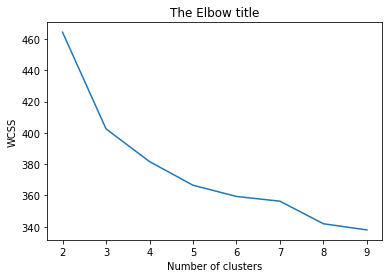

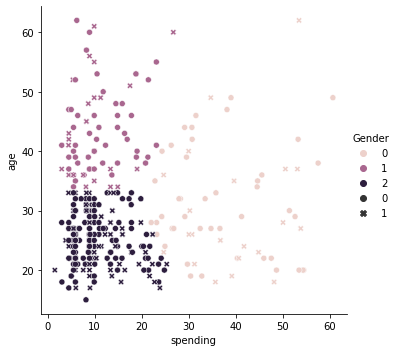

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

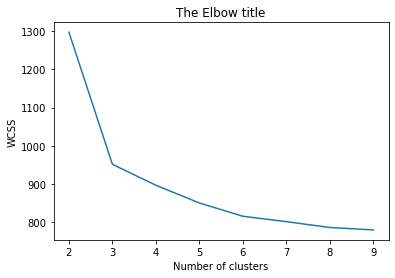

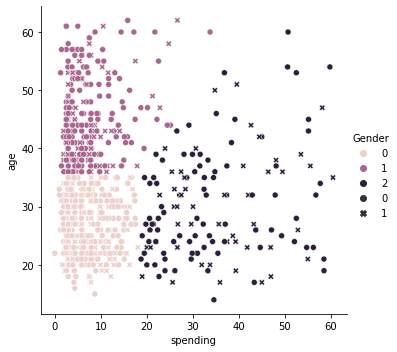

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

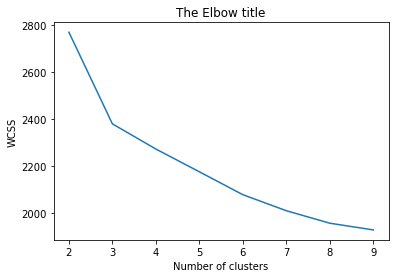

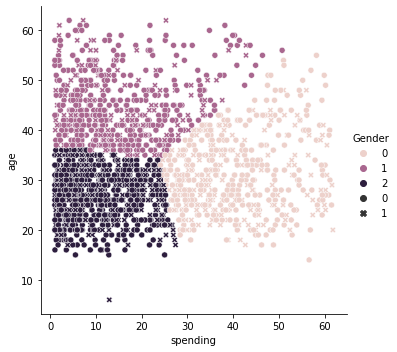

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

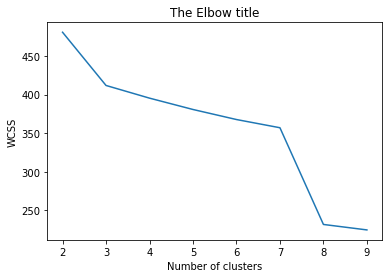

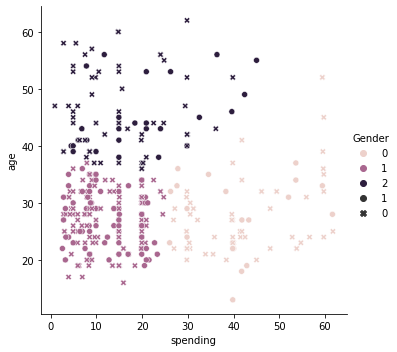

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

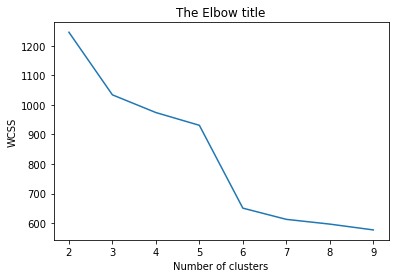

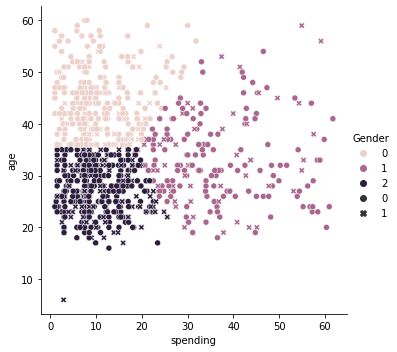

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

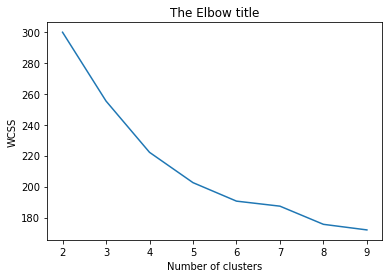

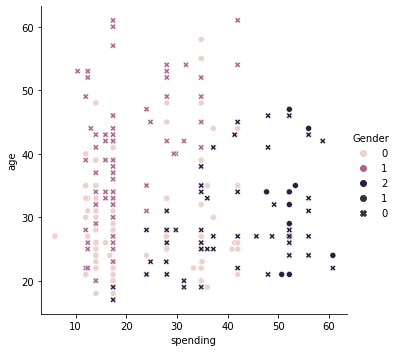

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

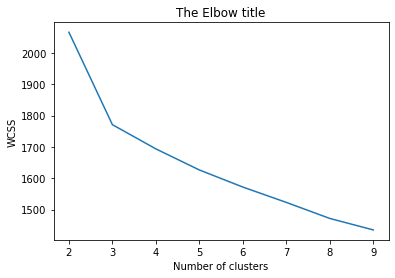

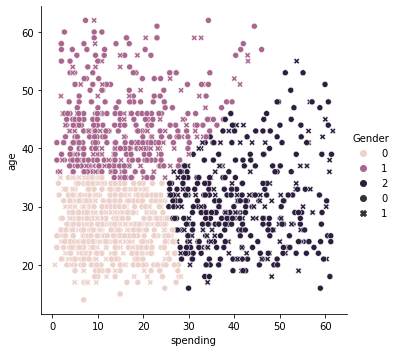

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

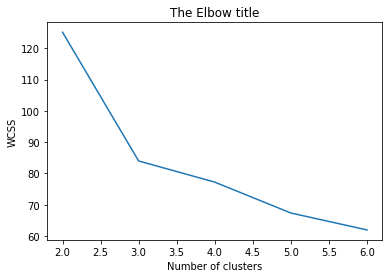

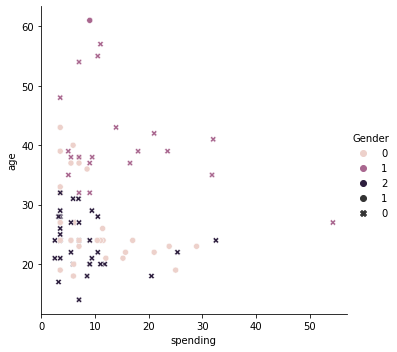

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

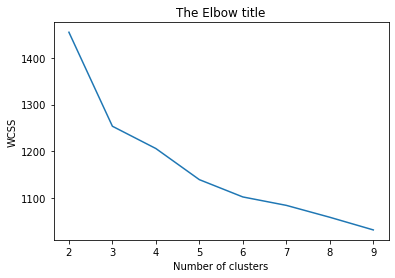

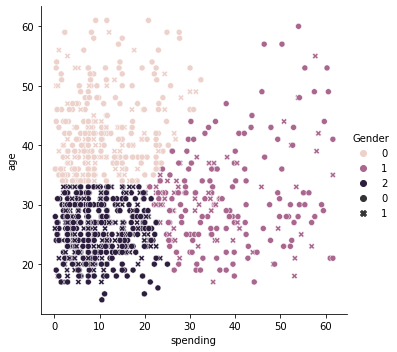

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

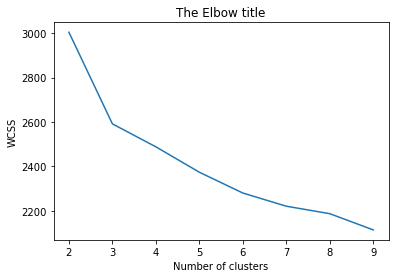

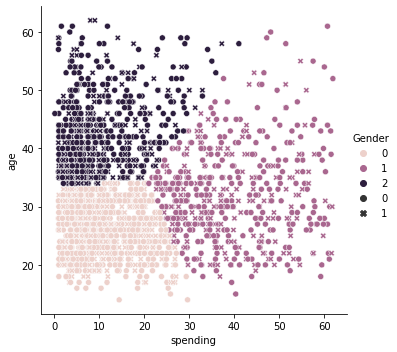

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

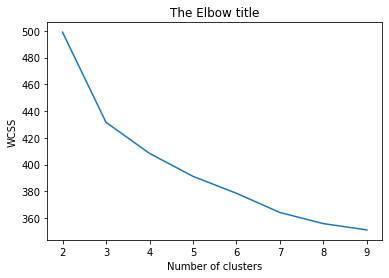

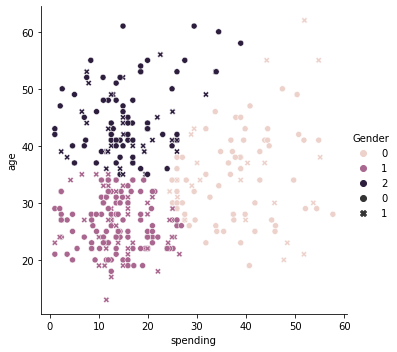

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

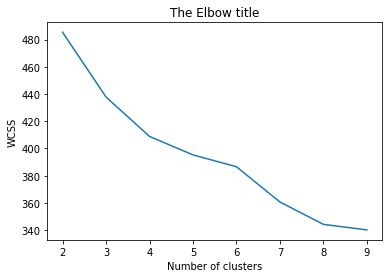

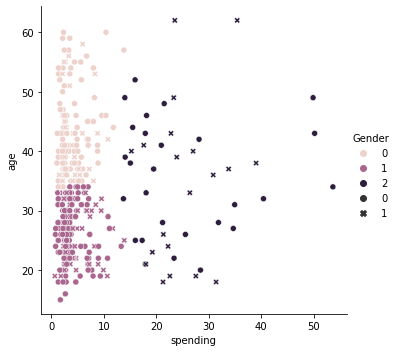

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

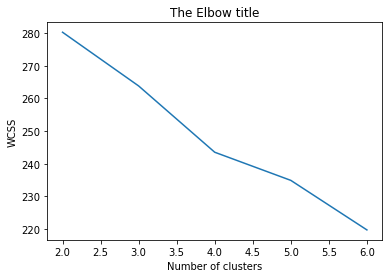

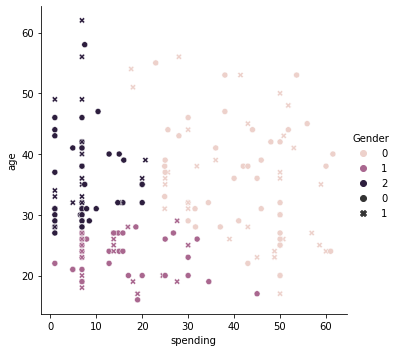

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

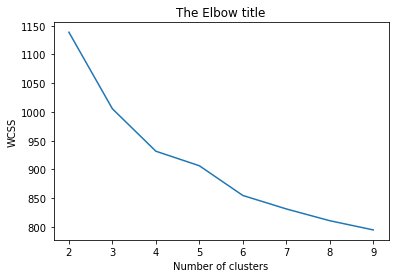

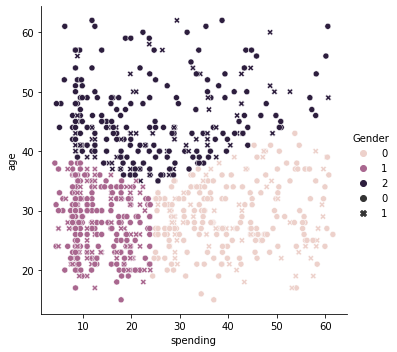

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

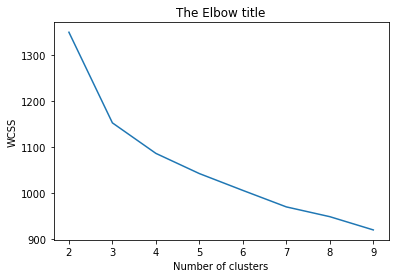

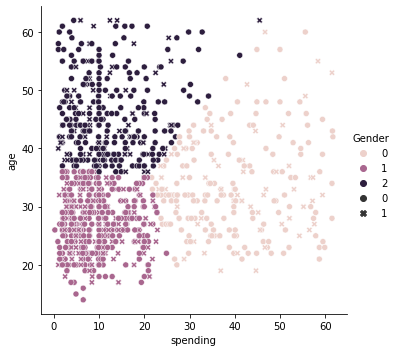

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

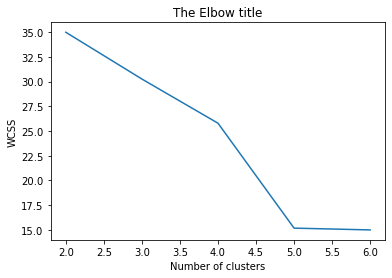

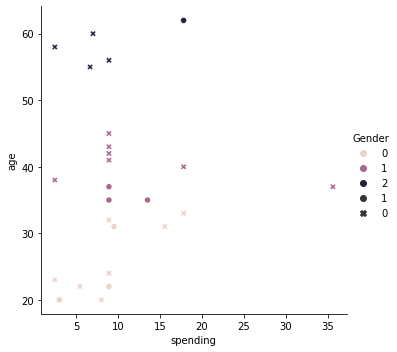

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

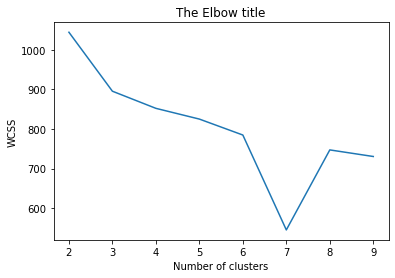

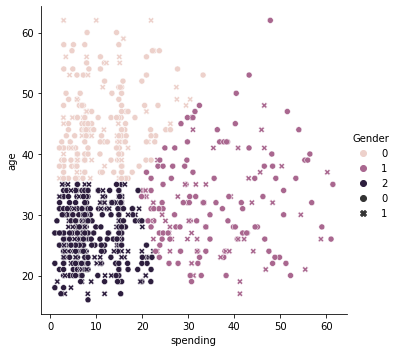

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

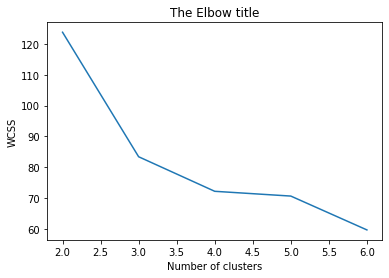

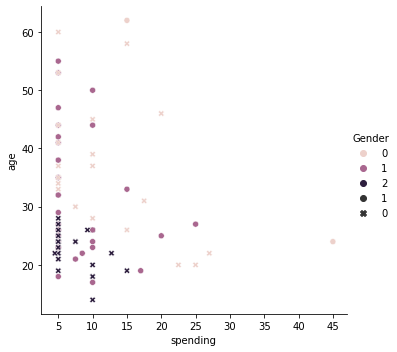

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

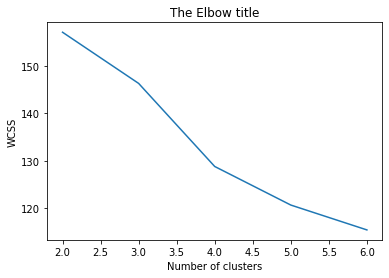

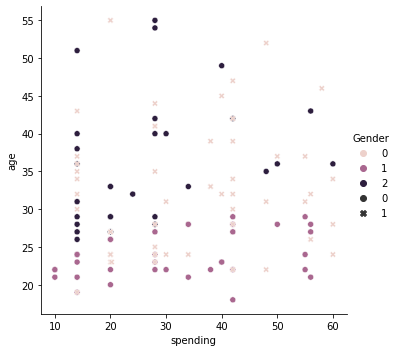

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

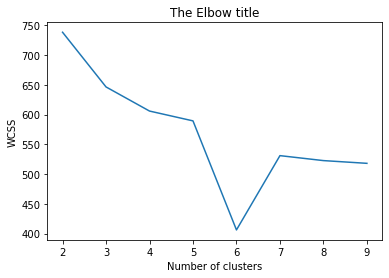

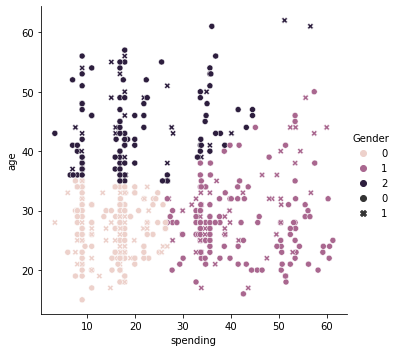

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

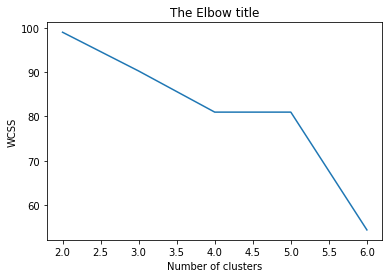

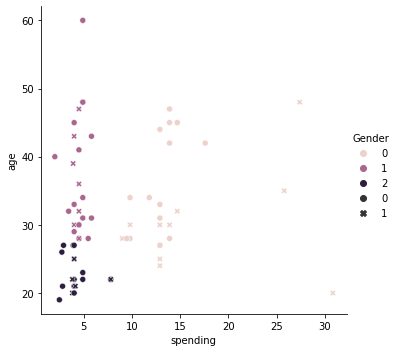

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

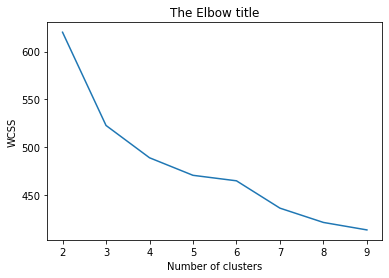

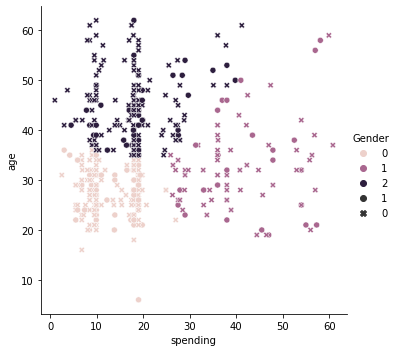

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

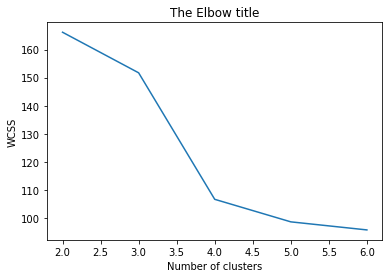

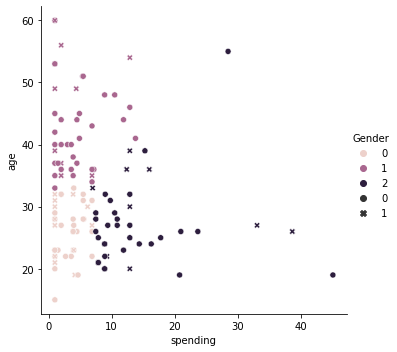

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

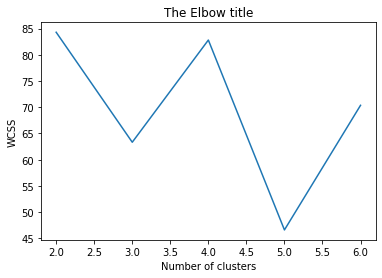

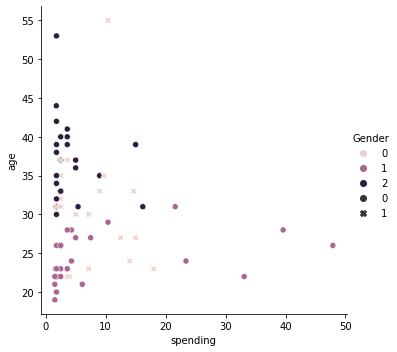

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

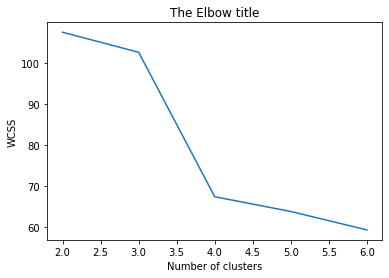

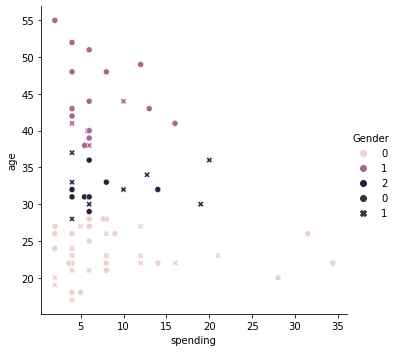

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

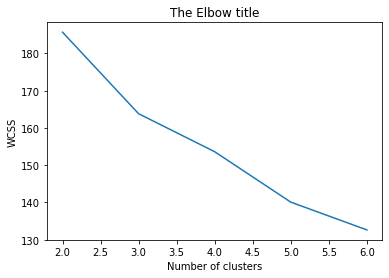

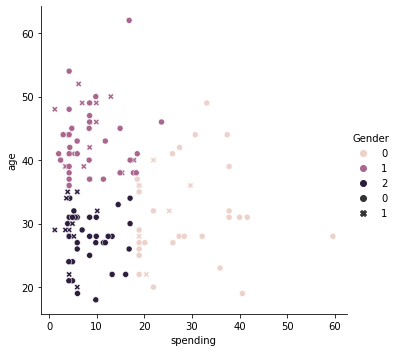

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

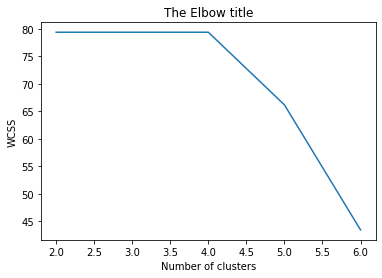

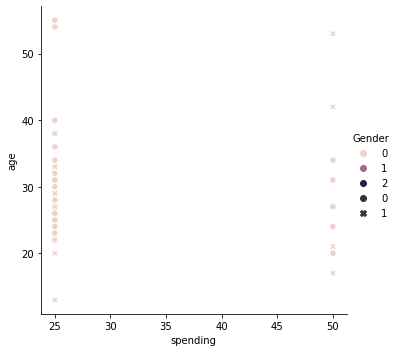

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

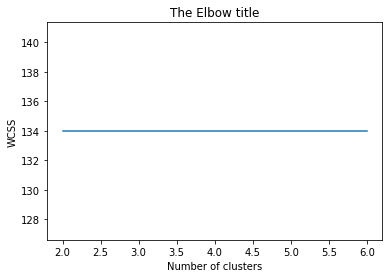

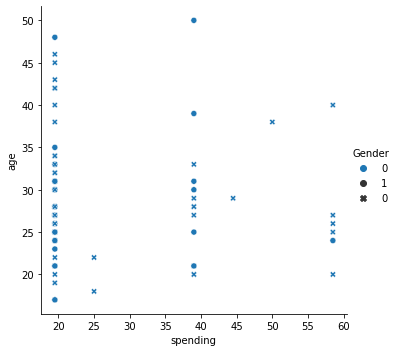

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

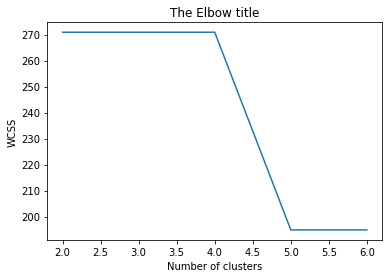

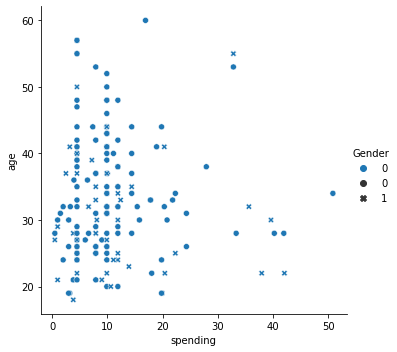

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

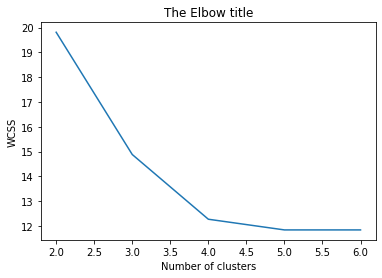

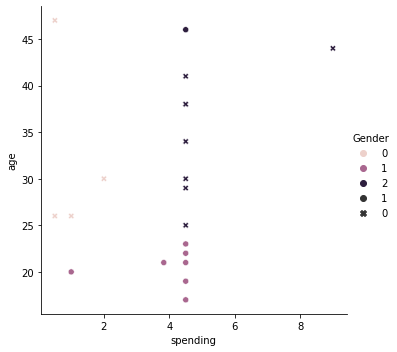

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

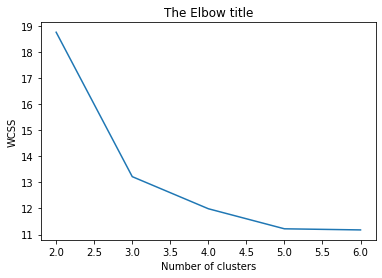

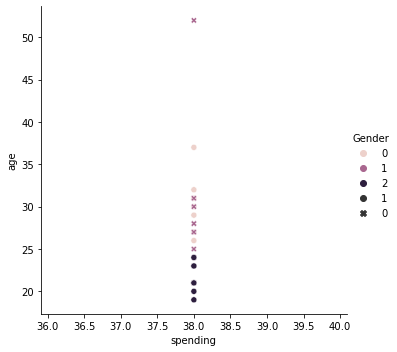

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

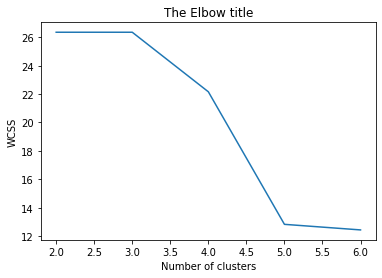

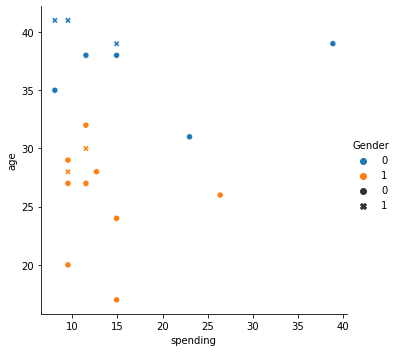

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

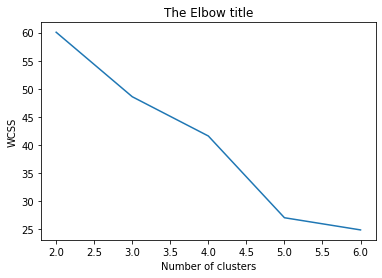

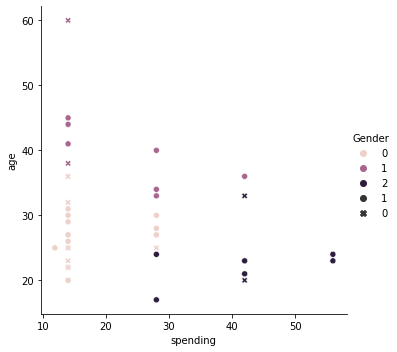

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

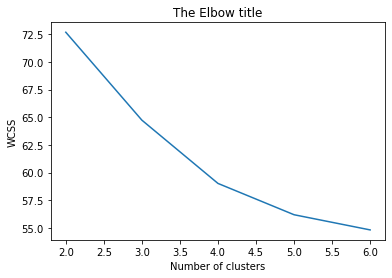

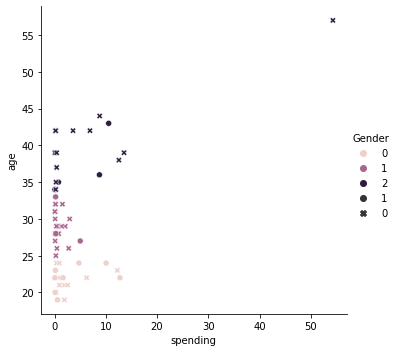

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/1220962558.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [20]:

for x in allgroups:
    
    
    test1 = spd5.loc[spd5['Groups']==x]
    test1
    ktest1 = test1[['Age','spending','Gender']]
    ktest1
    scaler = StandardScaler()
    stest1 = scaler.fit_transform(ktest1)
    dftest1 = pd.DataFrame(stest1,index = ktest1.index, columns = ktest1.columns)
    wcss=[]
    if (len(dftest1)>200):
        
        for i in range(2,10):
            kmedoids = KMedoids(metric = 'euclidean',n_clusters = i, init = 'heuristic', max_iter = 50)
            kmedoids.fit(dftest1)
            wcss_iter = kmedoids.inertia_
            wcss.append(wcss_iter)

        number_clusters = range(2,10)
        plt.plot(number_clusters,wcss)
        plt.title('The Elbow title')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        k1 = KneeLocator(range(2,10), wcss, curve = "convex", direction = "decreasing")
    else:
        for i in range(2,7):
            kmedoids = KMedoids(metric = 'euclidean',n_clusters = i, init = 'heuristic', max_iter = 50)
            kmedoids.fit(dftest1)
            wcss_iter = kmedoids.inertia_
            wcss.append(wcss_iter)

        number_clusters = range(2,7)
        plt.plot(number_clusters,wcss)
        plt.title('The Elbow title')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        k1 = KneeLocator(range(2,7), wcss, curve = "convex", direction = "decreasing")
    k1.elbow
    kmedoids = KMedoids(metric = "euclidean",n_clusters = 3, init= "heuristic",max_iter = 50)
    result2 = kmedoids.fit(dftest1)
    testp1 = spd5.loc[(spd5['Groups']== x)]
    sns.relplot(x = testp1['spending'], y=testp1['Age'],hue = result2.labels_,style = testp1['Gender'])
    plt.xlabel("spending")
    plt.ylabel("age")
    plt.show()
    ktest1['Cluster']= result2.labels_
    ktest2 = ktest1.groupby(['Cluster'])['Cluster'].count().reset_index(name="count")
    bestcluster = ktest2.loc[ktest2['count'].idxmax()][0]
    age = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][0]
    spending = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][1]
    gender = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][2]
    dftest1.loc[(dftest1['Age'] == age)&(dftest1['spending']==spending)&(dftest1['Gender']==gender),'bestcentroid'] = True
    bci = dftest1.loc[(dftest1['Age'] == age)&(dftest1['spending']==spending)&(dftest1['Gender']==gender)].index[0]
    ktest1.loc[bci,'Best Centroid'] = True
    ktest1.loc[ktest1['Best Centroid'] == True]
    for index, rows in ktest1.iterrows():
        spd5.loc[index,'Cluster'] = ktest1.loc[index,'Cluster']
        spd5.loc[index,'BestCluster'] = bestcluster
        spd5.loc[index,'Bestcentroid'] = ktest1.loc[index,'Best Centroid']
spd6 = spd5.groupby(['Groups','Cluster'])['Client_ID'].count()
spd7 = pd.DataFrame(spd6)
spd7
spd8 = spd7.loc[spd7.groupby(['Groups'])['Client_ID'].idxmax()]
    

In [21]:
spd5['Bestcentroid'] = spd5['Bestcentroid'].replace(np.nan,False)
spd5

C:\Users\JACK\AppData\Local\Temp/ipykernel_2108/2479011553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spd5['Bestcentroid'] = spd5['Bestcentroid'].replace(np.nan,False)


,Age,spending,Client_ID,Groups,Client_Name,Gender,Cluster,BestCluster,Bestcentroid
1,20.0,21.44,30989,ZUGO PRODUCE,JASON,0,2.0,2.0,False
3,32.0,2.90,290200,COOKED FOOD,SEAA SUE,0,0.0,0.0,False
4,45.0,5.90,301657,SNACK,Khoong Moh Ling,0,1.0,2.0,False
5,35.0,34.50,290174,HEALTH CARE,JEREMY TAN,1,0.0,1.0,False
6,27.0,9.00,101370,COOKING ESSENTIAL,TAN MIN EN,0,2.0,2.0,True
...,...,...,...,...,...,...,...,...,...
24919,28.0,18.00,10987,CANNING,Lin wai kong,1,0.0,0.0,False
24921,30.0,42.70,10970,COOKING ESSENTIAL,Bo Chang Soon,1,1.0,2.0,False
24924,39.0,23.50,4601021,FRIED FOOD,AMELIA LOOI,0,1.0,2.0,False
24925,25.0,15.80,14068,ALCOHOLIC BEVERAGE,Nicodemus ng qi xuan,1,0.0,0.0,False


In [22]:
spd5.to_excel("D:\cussegtest2.xlsx")

Age             39
spending        39
Client_ID       39
Groups          39
Client_Name     39
Gender          39
Cluster         39
BestCluster     39
Bestcentroid    39
dtype: int64

In [28]:
spd8 = spd7.loc[spd7.groupby(['Groups'])['Client_ID'].idxmax()]
spd8

,,Client_ID
Groups,Cluster,
ALCOHOLIC BEVERAGES,1.0,197
BEVERAGES,1.0,891


In [48]:
result2.cluster_centers_

array([[-0.24809586,  1.31125136, -0.68535311],
       [-0.57045366, -0.57931728, -0.68535311],
       [ 1.14878795, -0.44370687, -0.68535311]])

In [80]:
dftest2 = dftest1

In [91]:
bci = dftest2.loc[(dftest2['Age'] == age)&(dftest2['spending']==spending)&(dftest2['Gender']==gender)].index[0]
ktest1.loc[bci,'Best Centroid'] = True
ktest1.loc[ktest1['Best Centroid'] == True]

,Age,spending,Gender,Cluster,Best Centroid
608,27.0,7.8,0,1,True


In [92]:
ktest1

,Age,spending,Gender,Cluster,Best Centroid
3,33.0,34.83,1,0,NaN
10,24.0,10.90,0,1,NaN
28,38.0,27.20,0,0,NaN
29,20.0,10.30,1,1,NaN
48,37.0,11.00,1,2,NaN
...,...,...,...,...,...
27846,24.0,9.03,0,1,NaN
27881,22.0,3.90,0,1,NaN
27885,28.0,46.92,1,0,NaN
27890,44.0,9.40,0,2,NaN


In [81]:
age = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][0]
spending = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][1]
gender = result2.cluster_centers_[ktest2.loc[ktest2['count'].idxmax()][0]][2]
dftest2.loc[(dftest2['Age'] == age)&(dftest2['spending']==spending)&(dftest2['Gender']==gender),'bestcentroid'] = True


In [47]:
ktest1['centroidx'] = result2.cluster_centers_

ValueError: Length of values (3) does not match length of index (1868)

In [73]:
ktest2 = ktest1.groupby(['Cluster'])['Cluster'].count().reset_index(name="count")
ktest2.loc[ktest2['count'].idxmax()][0]


1

In [54]:
dftest1 = pd.DataFrame(stest1,index = ktest1.index, columns = ktest1.columns)
dftest1

,Age,spending,Gender
25,0.417687,-1.027027,1.643407
63,-1.146559,-0.245327,-0.608492
68,-1.733151,-0.901955,-0.608492
91,0.808748,-0.901955,1.643407
136,-1.439855,-1.175550,1.643407
...,...,...,...
27886,-1.146559,-1.050478,-0.608492
27895,-0.462201,-0.612726,-0.608492
27896,-0.071140,1.521315,-0.608492
27916,1.590871,-0.745615,-0.608492


In [59]:
dftest1.describe()

,Age,spending,Gender
count,9.400000e+02,9.400000e+02,9.400000e+02
mean,7.629831e-17,-1.299197e-16,-2.622016e-17
std,1.000532e+00,1.000532e+00,1.000532e+00
min,-2.026447e+00,-1.235741e+00,-6.084919e-01
25%,-7.554973e-01,-7.456154e-01,-6.084919e-01
50%,-1.689052e-01,-3.743079e-01,-6.084919e-01
75%,7.109829e-01,4.894706e-01,1.643407e+00
max,2.666290e+00,2.920558e+00,1.643407e+00


Text(0, 0.5, 'WCSS')

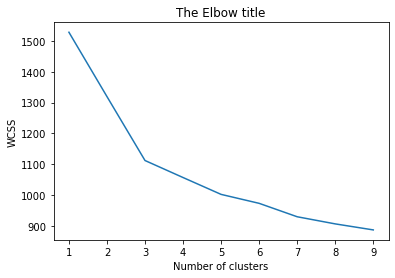

In [118]:
wcss=[]
for i in range(1,10):
    kmedoids = KMedoids(i)
    kmedoids.fit(dftest1)
    wcss_iter = kmedoids.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [120]:
k1 = KneeLocator(range(1,10), wcss, curve = "convex", direction = "decreasing")
k1.elbow

3

In [103]:
kmedoids = KMedoids(metric = "euclidean",n_clusters = 3, init= "heuristic",max_iter = 50)
result2 = kmedoids.fit(dftest1)

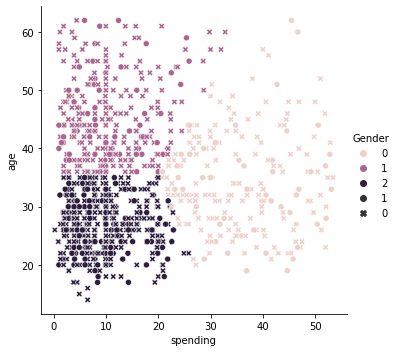

In [104]:
testp1 = spd5.loc[(spd5['Groups']== "FRESH PRODUCE")]
sns.relplot(x = testp1['spending'], y=testp1['Age'],hue = result2.labels_,style = testp1['Gender'])
plt.xlabel("spending")
plt.ylabel("age")
plt.show()

In [132]:
ktest1['Cluster']= result2.labels_
ktest1

C:\Users\JACK\AppData\Local\Temp/ipykernel_6108/3546611703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ktest1['Cluster']= result2.labels_


,Age,spending,Gender,cluster,Cluster
25,39.0,2.9,1,1,1
63,23.0,12.9,0,2,2
68,17.0,4.5,0,2,2
91,43.0,4.5,1,1,1
136,20.0,1.0,1,2,2
...,...,...,...,...,...
27886,23.0,2.6,0,2,2
27895,30.0,8.2,0,2,2
27896,34.0,35.5,0,0,0
27916,51.0,6.5,0,1,1


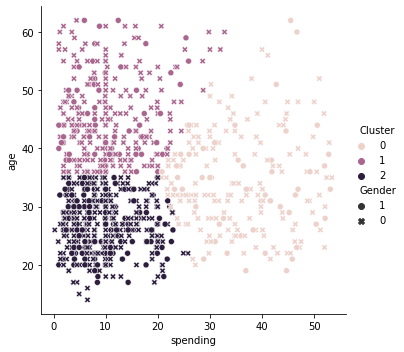

In [133]:
testp1 = spd5.loc[(spd5['Groups']== "FRESH PRODUCE")]
sns.relplot(x = ktest1['spending'], y=ktest1['Age'],hue = ktest1['Cluster'],style = ktest1['Gender'])
plt.xlabel("spending")
plt.ylabel("age")
plt.show()

In [152]:
for index, rows in ktest1.iterrows():
    spd5.loc[index,'Cluster'] = ktest1.loc[index,'Cluster']
    


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [239]:
spd6 = spd5.groupby(['Groups','Cluster'])['Client_ID'].count()
spd7 = pd.DataFrame(spd6)
spd7

Client_ID
Groups        Cluster           
FRESH PRODUCE 0.0            217
              1.0            307
              2.0            416

In [245]:
spd7.loc[spd7.groupby(['Groups'])['Client_ID'].idxmax()]

,,Client_ID
Groups,Cluster,
FRESH PRODUCE,2.0,416


In [238]:
spd7

Client_ID  count
Groups        Cluster                  
FRESH PRODUCE 0.0            217    416
              1.0            307    416
              2.0            416    416

In [196]:

cluster = spd6.index.max()[1]
groups = spd6.index.max()[0]



Groups         Cluster
FRESH PRODUCE  0.0        217
               1.0        307
               2.0        416
Name: Client_ID, dtype: int64

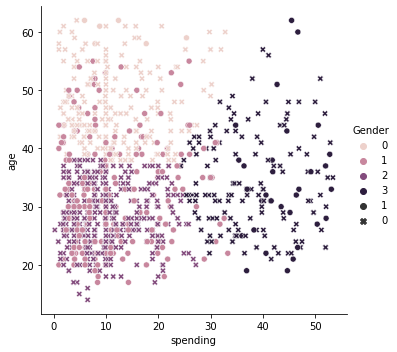

In [72]:
testp1 = spd5.loc[(spd5['Groups']== "FRESH PRODUCE")]
sns.relplot(x = testp1['spending'], y=testp1['Age'],hue = result.labels_,style = testp1['Gender'])
plt.xlabel("spending")
plt.ylabel("age")
plt.show()

In [51]:
fig = plt.figure(figsize=(20, 10))
customcmap = ListedColormap(["red", "yellow", "blue"])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(testp1['Age'],testp1['spending'],testp1['Gender'], 
            c=result.labels_.astype(float), 
           edgecolor="k", s=150, cmap=customcmap)
fig.show()

C:\Users\JACK\AppData\Local\Temp/ipykernel_6108/1013221102.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 1440x720 with 1 Axes>

In [37]:
result.labels_

array([2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2,
       0, 2, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1,
       1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 1,
       2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1,
       1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 1, 2, 0,
       2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2,
       0, 0, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 0, 1, 2, 0, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2,
       1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1,
       0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 0,

In [ ]:
x = spd[['Age','spending']]
x

In [52]:
spd

,Age,spending,Client_ID,ItemCode,SalesMade
0,40.0,9.141522,1010,6225000313712,9.9
1,40.0,9.141522,1010,6902265114918,29.7
2,40.0,9.141522,1010,6905734401014,12.8
3,40.0,9.141522,1010,8801007792736,0.0
4,40.0,9.141522,1010,8801047181323,9.0
...,...,...,...,...,...
83849,2021.0,15.142857,908,6972890396799,20.0
83850,2021.0,15.142857,908,6972890397451,10.0
83851,2021.0,15.142857,908,6972890399493,14.0
83852,2021.0,15.142857,908,6974491920502,10.0


In [82]:
a = spd.loc[(spd['Age']<1000 )&(spd['Age']>10)&(spd['spending']<200)]
a

,Age,spending,Client_ID,ItemCode,SalesMade
0,40.0,9.141522,1010,6225000313712,9.90
1,40.0,9.141522,1010,6902265114918,29.70
2,40.0,9.141522,1010,6905734401014,12.80
3,40.0,9.141522,1010,8801007792736,0.00
4,40.0,9.141522,1010,8801047181323,9.00
...,...,...,...,...,...
83836,43.0,10.803889,905,ZUGO1018,5.00
83837,43.0,10.803889,905,ZUGO1028,5.90
83838,43.0,10.803889,905,ZUGO1032,11.60
83839,43.0,10.803889,905,ZUGO1042,8.50


In [83]:
a['Age'].unique()

array([40., 41., 23., 27., 30., 24., 53., 21., 31., 35., 47., 33., 61.,
       63., 59., 42., 44., 36., 29., 22., 28., 20., 25., 18., 77., 26.,
       39., 37., 38., 49., 43., 45., 74., 46., 48., 50., 32., 51., 57.,
       54., 64., 52., 56., 34., 17., 55., 19., 60., 66., 58., 16., 68.,
       62., 15., 65., 69., 71., 80., 72., 13., 67., 70., 14., 85., 73.])

Text(0.5, 1.0, 'Age')

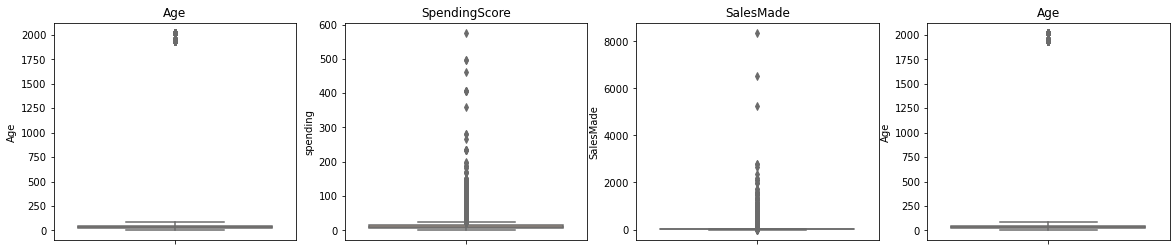

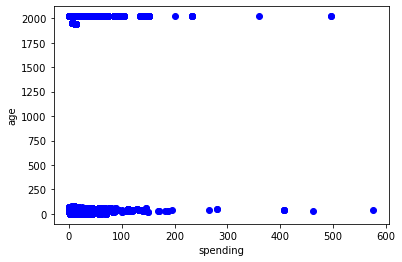

In [7]:
plt.scatter(x = spd['spending'], y=spd['Age'],c = 'blue')
plt.xlabel("spending")
plt.ylabel("age")
plt.show()

In [106]:
age

array([[ 0.68904355, -0.3207508 ],
       [ 0.68904355, -0.3207508 ],
       [ 0.68904355, -0.3207508 ],
       ...,
       [ 0.97936928, -0.16651979],
       [ 0.97936928, -0.16651979],
       [ 0.97936928, -0.16651979]])

In [86]:
test = a[['Age','spending']]
test

,Age,spending
0,40.0,9.141522
1,40.0,9.141522
2,40.0,9.141522
3,40.0,9.141522
4,40.0,9.141522
...,...,...
83836,43.0,10.803889
83837,43.0,10.803889
83838,43.0,10.803889
83839,43.0,10.803889


                    Alpha      Beta      Gamma         Mu      Sigma    Lambda           AICc            BIC
Distribution                                                                                                
Gamma_3P         5.333155  3.738209  12.944653                                  480366.683080  480393.960318
Lognormal_2P                                     3.446387   0.302591            482081.563741  482099.748628
Lognormal_3P                          9.235142   3.069546   0.437018            480868.537358  482099.748628
Weibull_3P      22.530908  2.049534  12.994656                                  482883.889793  482911.167031
Gamma_2P         3.012676  10.91424                                             484130.862010  484149.046896
Normal_2P                                       32.881073  10.333132            493160.543794  493178.728681
Weibull_2P      36.603236  3.302869                                             493832.525392  493850.710278
Exponential_2P     

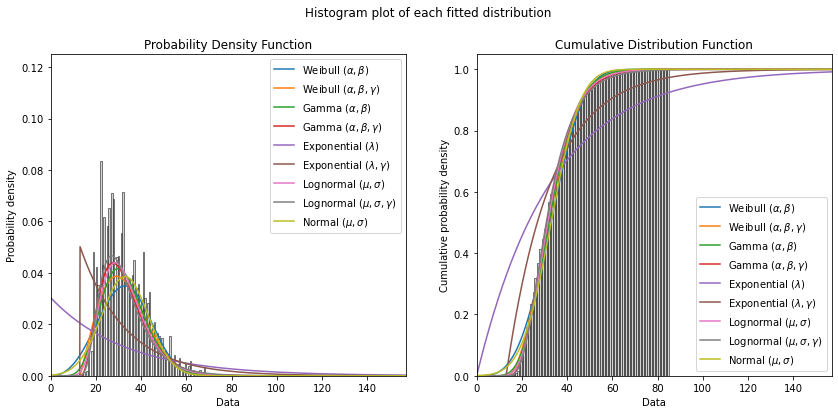

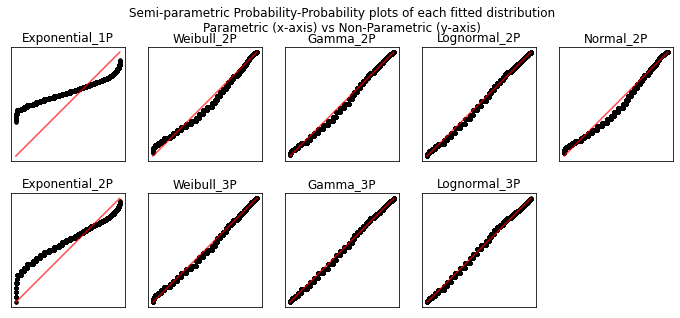

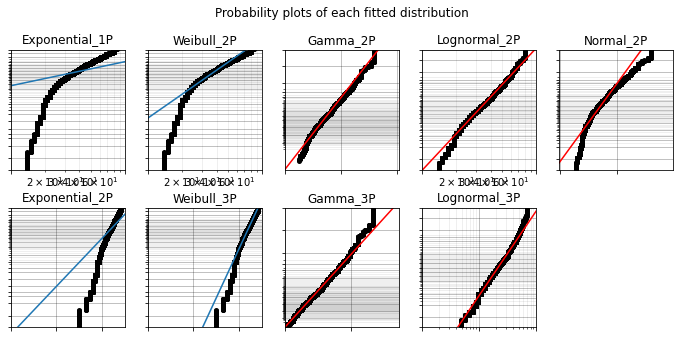

In [21]:
# Identify the distribution and fitting all distribution to the platelets feature
from reliability.Fitters import Fit_Everything
Fit_Everything(failures=np.array(a['Age']), show_histogram_plot=True, show_probability_plot=True, show_PP_plot=True)
plt.show()

In [87]:
test2= a[['Age','spending']]
test2


,Age,spending
0,40.0,9.141522
1,40.0,9.141522
2,40.0,9.141522
3,40.0,9.141522
4,40.0,9.141522
...,...,...
83836,43.0,10.803889
83837,43.0,10.803889
83838,43.0,10.803889
83839,43.0,10.803889


In [88]:
scaler = StandardScaler()
age = scaler.fit_transform(test2)

In [89]:
age

array([[ 0.68904355, -0.3207508 ],
       [ 0.68904355, -0.3207508 ],
       [ 0.68904355, -0.3207508 ],
       ...,
       [ 0.97936928, -0.16651979],
       [ 0.97936928, -0.16651979],
       [ 0.97936928, -0.16651979]])

Text(0, 0.5, 'WCSS')

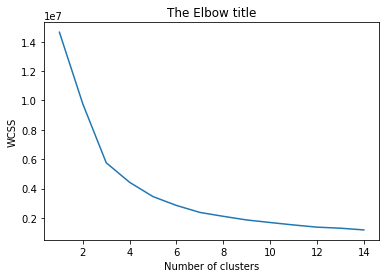

In [108]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,15):
    kmeans = KMeans(i)
    kmeans.fit(test)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,15)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [109]:
k1 = KneeLocator(range(1,15), wcss, curve = "convex", direction = "decreasing")
k1.elbow

4

In [111]:
kmeans = KMeans(
    n_clusters = k1.elbow,
    init = "k-means++",
    n_init = 50,
    max_iter = 50, 
    random_state = 42)
result = kmeans.fit(test)

In [112]:
result.cluster_centers_

array([[31.5954721 , 29.65944366],
       [26.41643575,  9.62212203],
       [44.49905033, 10.45147768],
       [40.28263003, 72.26552502]])

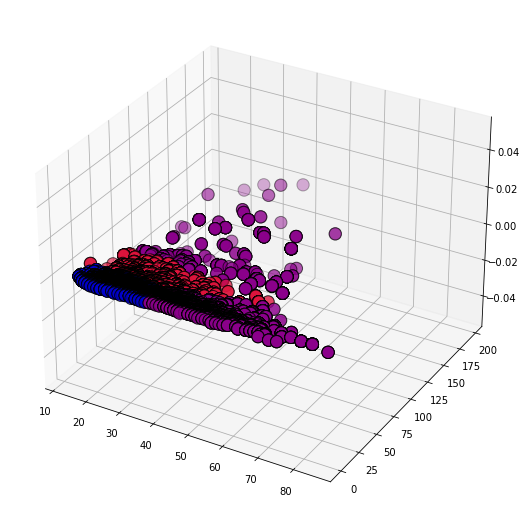

In [113]:
fig = plt.figure(figsize=(20, 10))
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(test['Age'],test['spending'], 
            c=result.labels_.astype(float), 
           edgecolor="k", s=150, cmap=customcmap)
fig.show()

In [60]:
spd[spd['spending']>300]

,Age,spending,Client_ID,ItemCode,SalesMade
41020,40.0,576.000,140360,8801047181323,576.0
71242,41.0,406.275,30562,7394376123337,19.9
71243,41.0,406.275,30562,8854761951581,20.9
71244,41.0,406.275,30562,9555277321118,1582.0
71245,41.0,406.275,30562,9556404118076,2.3
74112,2021.0,495.900,30755,76239878,991.8
74113,2021.0,495.900,30755,9555289101531,0.0
78636,2021.0,360.000,310146,CNY10031,360.0
79032,28.0,462.000,310184,6974491921974,462.0
